In [1]:
from multiprocessing import cpu_count

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN, KMeans

# Imports
import os,sys
import re
import string
import math
import pickle

import re, numpy as np, pandas as pd
from pprint import pprint
from collections import OrderedDict


# Gensim
import gensim,  logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.summarization import summarize,keywords
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel,TfidfModel

# Plotting & graphs
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS

# Spacy 
import spacy

#import Utils
from utils import get_corpus_dataframe

import re
import pandas as pd
import os, sys
import glob
import string
import pickle
from pathlib2 import Path


# Basic configuration 
%matplotlib inline
warnings.filterwarnings('ignore') 
#warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [2]:
# variables Initialize 

allowed_postags_filter=['NOUN', 'ADJ', 'VERB', 'ADV'] 

# Prepare Plotting:  Helpers & Initialization
word_plotting_colors = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

def my_tf_color_func(dictionary):
    def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
        return "hsl(%d, 80%%, 50%%)" % (360 * dictionary[word])
    return my_tf_color_func_inner

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: word_plotting_colors[i],
                  prefer_horizontal=1.0)

In [3]:
nlp = spacy.load('en_core_web_sm', disable=['ner']) #nlp = spacy.load("en", disable=['ner'])

stop_words = list(spacy.lang.en.stop_words.STOP_WORDS)
    
stop_words.extend(['ai', 'ii' , 'iii' ,'iv',  'ref','www', 'new', 're', 'edu', 'use', 'not', 'would', 'say', 'could', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come','set'])
stop_words.extend(['usa','united_states','united_state', 'american','finland','finnish', 'luxembourg','french', 'france','china','chinas' , 'italy' ,'italian', 'india', 'indian', 'mexico','mexican', 'japan' ,'denmark', 'danish', 'uk','uks','british', 'united_kingdom','germany','german', 'canada' , 'canadian' , 'sweden','london','edinburgh', 'cambridge','stanford'])
stop_words.extend(['strategy','strategic','federal','council','ministry','minister','parliament','appendix'])
stop_words.extend(['villani', 'mathematician','author','woman','niti_aayog' , 'july','report','white_paper','pdf','alan_turing_institute','dkk_million_eur_million','ki_strategie'])
stop_words.extend(['table', 'action','author','st','greece','greek'])

# Allowed Parts of Speech filter
allowed_postags_filter=['NOUN', 'ADJ', 'VERB', 'ADV']

def load_documents(eu_only=False):
    eu_list = ['denmark','france','germany','italy','sweden','uk','finland','luxembourg','greece']
    file_list = glob.glob(os.path.join(os.getcwd(), ".\\txts\\clean\\"+ "*.txt"))
            
    corpus = {}

    for file_path in file_list:
        filename = Path(Path(file_path).stem).stem
        if not eu_only or (eu_only and filename in eu_list):
            with open(file_path,encoding='utf-8',newline=None) as f_input:
                text = f_input.read().replace("\n", " ")
                clean_text = "".join([c for c in text if c.isprintable()])
                corpus[filename]= clean_text

    return corpus 

#clean data
def clean_document(doc,remove_digits=False , remove_non_printable=False):

   
    # Remove Emails
    doc = re.sub('\S*@\S*\s?', '', doc) 

    #Remove Links & Urls
    doc = re.sub('http\S+', ' ', doc) 

    # Remove new line characters
    doc = re.sub('\s+', ' ', doc) 

    # Remove distracting single quotes
    doc = re.sub("\'", "", doc)
    
    # Remove digits
    if (remove_digits):
        doc = re.sub('\d+', '', doc)

    # Remove non printable chars
    if (remove_non_printable):
        doc = re.sub('[^a-zA-z\s]', '', doc)

    return doc

def load_strategy(sname):

    file_list = glob.glob(os.path.join(os.getcwd(), ".\\txts\\clean\\"+ "*.txt"))
    corpus = {}

    for file_path in file_list:
        filename = Path(Path(file_path).stem).stem
        if filename==sname:
            with open(file_path,encoding='utf-8',newline=None) as f_input:
                text = f_input.read().replace("\n", " ")
                clean_text = "".join([c for c in text if c.isprintable()])
                corpus[filename]= clean_text

    return corpus 

def get_corpus_dataframe(eu_only=False,allowed_postags_filter=['NOUN', 'ADJ', 'VERB', 'ADV']):
    savedmodel_filename = f'documentGR'
    documents = load_documents(eu_only=eu_only)
    df = pd.DataFrame.from_dict(documents, orient='index', columns=['content'])
    df.index.names = ['country']

    # clean content
    df['clean_content'] = df['content'].map(lambda doc: clean_document(doc,remove_digits=True))   

    # calculate keywords using TExtRank
    df['keywords'] = df['content'].map(lambda doc: keywords(doc, ratio=0.2,words=20,lemmatize=True,pos_filter=allowed_postags_filter))  #the ratio will be ignored 
    df['clean_keywords'] = df['clean_content'].map(lambda doc: keywords(doc, ratio=0.2,words=20,lemmatize=True,pos_filter=allowed_postags_filter))  #the ratio will be ignored 


    # calculate summaries using TExtRank
    df['summary'] = df['content'].map(lambda doc: summarize(doc, ratio=0.2,word_count=200))  #the ratio will be ignored 
    df['clean_summary'] = df['clean_content'].map(lambda doc: summarize(doc, ratio=0.2,word_count=200))  #the ratio will be ignored 

    #save pickle (for reload)
    df.to_pickle(savedmodel_filename+'.pkl')

    #save excel
    df_export = df.copy()
    df_export['content'] = df_export['content'].str.slice(0,32766)
    df_export['clean_content'] = df_export['clean_content'].str.slice(0,32766)
    #df_export.to_excel(savedmodel_filename+'.xls')
    
    return df

# Split documents to words
def doc_to_words(documents):
    for doc in documents:
        doc = gensim.utils.simple_preprocess(str(doc), deacc=True) 
        yield(doc)  


 


# Load data 
# Import Dataset into a Pandas Dataframe
df = get_corpus_dataframe()
data = df.clean_content.values.tolist()
data_words = list(doc_to_words(data))



In [46]:
data = df.clean_content.values.tolist()
data_words = list(doc_to_words(data))

# Build the bigram and trigram models
ngram_common_terms = ["of", "with", "without", "and", "or", "the", "a" ,"as","th","de","la","du"]

bigram = gensim.models.Phrases(data_words, common_terms=ngram_common_terms, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words],common_terms=ngram_common_terms , min_count=5, threshold=50)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

correct_lemma = lambda token: str(token) if '_' in str(token) else token.lemma_

def process_words_spacy(texts, stop_words=stop_words, allowed_postags=allowed_postags_filter,promote_ngrams=False):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts] 

    
    texts_out = []
    for text in texts:
        
        #promote ngrams
        if promote_ngrams:
            text+= [ngram for ngram in text if '_' in ngram]
            text+= [ngram for ngram in text if '_' in ngram]
        
        doc = nlp(" ".join(text)) 
        
        #lematize using spacy
        texts_out.append([correct_lemma(token) for token in doc if token.pos_ in allowed_postags or  '_' in str(token) ])
                       
          
    # remove stopwords once more after lemmatization and 
    #texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]  
    texts_out = [[word for word in doc if word not in stop_words] for doc in texts_out] 
    
    # remove words that are not in the english vocabulary
    texts_out = [[word for word in doc if word in nlp.vocab or '_' in str(word)] for doc in texts_out]    
    return texts_out

data_ready = process_words_spacy(data_words,promote_ngrams=False)  # processed Text Data!

# Save documents to file

with open("data_ready_GR.sav", "wb") as fp:   #Pickling
    pickle.dump(data_ready, fp)

In [4]:
with open("data_ready_GR.sav", "rb") as fp:   # Unpickling
    data_ready = pickle.load(fp)

In [5]:
#df['summary2'] = df['content'].map(lambda doc: summarize(doc, ratio=0.2,word_count=800))
#df['clean_summary2'] = df['clean_content'].map(lambda doc: summarize(doc, ratio=0.2,word_count=300))  #the ratio will be ignored 
#df['clean_summary2']['greece']

data_ready

[['state',
  'issue',
  'seminal',
  'document',
  'generation',
  'artificial_intelligence',
  'development',
  'plan',
  'important',
  'aspirational',
  'document',
  'level',
  'design',
  'blueprint',
  'countrys',
  'approach',
  'develop',
  'artificial_intelligence',
  'technology',
  'application',
  'broad',
  'goal',
  'find',
  'text',
  'document',
  'translator',
  'produce',
  'analysis',
  'document',
  'translate',
  'group',
  'experience',
  'chinese',
  'deep',
  'background',
  'subject',
  'matter',
  'establishment',
  'current',
  'capability',
  'leiden',
  'comment',
  'help',
  'improve',
  'translation',
  'error',
  'translation',
  'responsibility',
  'translator',
  'welcome',
  'comment',
  'direct',
  'address',
  'state',
  'issuance',
  'generation',
  'artificial_intelligence',
  'development',
  'plan',
  'generation',
  'artificial_intelligence',
  'development',
  'plan',
  'rapid',
  'development',
  'artificial_intelligence',
  'profoundly',
  '

In [48]:

all_docs= ''.join((''.join(map(str, data_ready))))

keywords(all_docs, ratio=0.2,words=60,scores=True,lemmatize=True,deacc=False)

#summarize(' '.join(df['content']), ratio=0.2,word_count=200)
#df['content'].values



[('developed', 0.18513760716344105),
 ('technologically', 0.1672244622100135),
 ('researcher', 0.1578658199094478),
 ('artificial_intelligence', 0.1371515735435924),
 ('governed', 0.11446001092255302),
 ('providing', 0.11153756357950358),
 ('applicative', 0.10381276866198638),
 ('sectoral', 0.10289681582675422),
 ('supportive', 0.1011378434316252),
 ('working', 0.09965608577528202),
 ('innovating', 0.09610176961495744),
 ('include', 0.09543601386425653),
 ('industrys', 0.09249308270180348),
 ('publically', 0.09055742308982159),
 ('example', 0.0892825156885003),
 ('base', 0.08780617580044271),
 ('service', 0.08712220875257212),
 ('area', 0.08604273611907425),
 ('required', 0.08541744365183175),
 ('create', 0.0830795051721857),
 ('digitized', 0.08230686248736058),
 ('processable', 0.08158230667869215),
 ('established', 0.08110223304182852),
 ('busy', 0.0810530347486037),
 ('possibly', 0.08064723475566458),
 ('initiator', 0.08048335520424194),
 ('company', 0.07997604754684003),
 ('accesse

In [6]:
def remove_common_words(dictionary,corpus,low_value=0.01):
    
    tfidf = TfidfModel(corpus, id2word=id2word)

    for i in range(0, len(corpus)):
        bow = corpus[i]
        low_value_words = [] #reinitialize to be safe. You can skip this.
        tfidf_ids = [id for id, value in tfidf[bow]]
        bow_ids = [id for id, value in bow]
        low_value_words = [id for id, value in tfidf[bow] if value < low_value]
        words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

        new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  

        #reassign        
        corpus[i] = new_bow
    return corpus

In [14]:
N_TOPICS = 4 #or 7
NO_ABOVE=1

# Create Dictionary
id2word = corpora.Dictionary(data_ready)


# Filter out words that occur less than 2 documents, or more than 85% of the documents.
id2word.filter_extremes(no_below=2, no_above=NO_ABOVE,keep_n=4600)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

#filter out most common words
#corpus= remove_common_words(id2word,corpus,low_value = 0.15)
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=N_TOPICS, 
                                           random_state=100,
                                           update_every=0,
                                           chunksize=1,
                                           passes=20,
                                           iterations=100,
                                           alpha='auto',
                                           #minimum_probability=0.15,
                                           per_word_topics=True)
                                           
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

pprint(lda_model.print_topics(num_words=30))
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Number of unique tokens: 3458
Number of documents: 13
[(0,
  '0.001*"technology" + 0.001*"research" + 0.001*"development" + '
  '0.001*"service" + 0.001*"support" + 0.001*"provide" + 0.001*"public" + '
  '0.001*"government" + 0.001*"sector" + 0.001*"project" + '
  '0.001*"artificial_intelligence" + 0.001*"solution" + 0.001*"system" + '
  '0.001*"create" + 0.001*"work" + 0.001*"industry" + 0.001*"example" + '
  '0.001*"ensure" + 0.001*"infrastructure" + 0.001*"application" + '
  '0.001*"develop" + 0.001*"innovation" + 0.001*"access" + 0.001*"include" + '
  '0.001*"area" + 0.001*"platform" + 0.001*"level" + 0.001*"process" + '
  '0.001*"increase" + 0.001*"digital"'),
 (1,
  '0.002*"research" + 0.001*"artificial_intelligence" + 0.001*"technology" + '
  '0.001*"support" + 0.001*"public" + 0.001*"development" + 0.001*"business" + '
  '0.001*"level" + 0.001*"develop" + 0.001*"system" + 0.001*"solution" + '
  '0.001*"application" + 0.001*"data" + 0.001*"digital" + 0.001*"include" + '
  '0.001

## PRINT STATISTICS

### Print Top Words per Topic

In [8]:
from operator import itemgetter
from collections import OrderedDict
from collections import defaultdict

# the higher the TF*IDF score (weight), the rarer the term and vice versa
tfidf = TfidfModel(corpus, id2word=id2word)
d = {}
low_value = 0.005
low_value_words = []
for bow in corpus:
    d={id2word[key]: value for (key, value) in tfidf[bow] if value < low_value}
    sorted_x = OrderedDict(sorted(d.items(), key=lambda t: t[1]))
    print(sorted_x)
    low_value_words += [id for id, value in tfidf[bow] if value > low_value]


#print low value words
for x in [id2word[word_id ] for word_id  in low_value_words]:
    print(x)

print(sorted_x)


OrderedDict([('access', 0.0006286206416086105), ('automate', 0.0006286206416086105), ('case', 0.0006286206416086105), ('consumer', 0.0006286206416086105), ('crucial', 0.0006286206416086105), ('currently', 0.0006286206416086105), ('decision', 0.0006286206416086105), ('digital', 0.0006286206416086105), ('fast', 0.0006286206416086105), ('figure', 0.0006286206416086105), ('free', 0.0006286206416086105), ('help', 0.0006286206416086105), ('live', 0.0006286206416086105), ('look', 0.0006286206416086105), ('multiple', 0.0006286206416086105), ('priority', 0.0006286206416086105), ('productivity', 0.0006286206416086105), ('raise', 0.0006286206416086105), ('regional', 0.0006286206416086105), ('significant', 0.0006286206416086105), ('term', 0.0006286206416086105), ('transfer', 0.0006286206416086105), ('trust', 0.0006286206416086105), ('actively', 0.001257241283217221), ('age', 0.001257241283217221), ('approach', 0.001257241283217221), ('computer', 0.001257241283217221), ('content', 0.001257241283217

real_time
real_world
realistic
realistically
realization
realize
reason
reasonable
reasoning
recognition
reconstruction
reflection
reform
regulation
related
relative
release
rely
remote
repetitive
replicable
requirement
reserve
resource
response
result
risk
robot
robotic
round
safe
safety
sale
sample
scale
scene
scholarship
science
scientific
scientist
sea
secondary_schools
secrecy
sectoral
security
segment
seize
self
self_driving
semantic
semi
sense
sensing
sensitivity
sensor
sensory
series
session
setting
setup
shape
sharing
ship
short
sight
sighted
simultaneous
situational
sixth
size
sized
smart
smart_cities
smooth
sociology
software
soil
sort
space
special
specialized
speech_recognition
sphere
stability
stage
station
statistical
stimulate
storage
stored
strive
strongly
structural
structure
struggle
study
style
substantially
sudden
suit
suitable
summarize
super
supercomputer
supervise
supervised
supervision
supply
supply_chain
surgical
sustainable
swarm
swarm_intelligence
systematic

consider
considerable
consideration
constant
constantly
consultancy
contact
contain
context
contract
contractual
contribute
copyright
customer
cut
damage
day
debate
decide
democratic
departure
depend
describe
detail
detect
determine
developer
developing
dialogue
dictate
different_types
digital_transformation
disability
discrimination
discuss
discussion
dissemination
distinguish
draw
driver
driverless
drone
educate
elite
embrace
employ
enable
energy_consumption
energy_efficient
enjoy
enquiry
enrolment
entail
entirely
equal
equality
equity
essential
estimate
ethical_issues
european
european_commission
exactly
example
exclusive
expect
expedite
expertise
explain
exploit
exploitation
export
extent
extremely
failure
fair
faulty
feature
feel
file
final
finally
financially
firm
fit
flow
footprint
forefront
forthcoming
fraud
freedom
freely_available
fuel
fulfil
function
gear
gender
generally
generate
giant
grant
greener
grid
hand
hear
heart
heavy
higher_education_institutions
historical
hold
ho

broadening
broader
cabinet
camera
certificate
cf
character
citizen_science
co_creation
coalition
commensurate
commodity
compilation
compliant
comprehensible
consistently
constitution
consultation_process
cross_border
curate
curation
decentralised
dependency
disclose
discover
discretion
distortion
earthquake
easier
empirical
enabler
encouraging
environmentally_friendly
established
eu
evidence_based
expansion
feasibility
feeding
fintech
foreword
gigabit
governing
gross
holistic
holistic_approach
human_centric
humane
imparting
improper
insight
intellectual
intention
interpret
irrespective
labelling
legal_certainty
marketable
merge
mitigation
molecular
monotonous
multilateral
nervous
neutral
outcomes
overview
pan_european
parking
penetration
pillar
playing
positioned
predictable
prominently
promotional
protection_rules
regulating
regulatory_framework
remuneration
render
repeatedly
respective
revisit
rigorous
rural
savvy
scarce
self_employed
socio
sociological
spin
spin_offs
stabilise
stand

early_stage
earn
ease
embark
emerging_economies
emerging_technologies
empower
emptive
enforce
enforcement
engagement
enrich
enroll
entry
envisage
equitable
essence
essentially
estate
estimation
ethical_considerations
european_union
evolve
executive
executive_summary
exercise
exhaustive
existence
existent
expenditure
expense
experimental
explainable
explanation
explicit
exponential
exponentially
exposure
extended
extra
extract
extraordinary
eye
facebook
facilitation
fact
fail
fairness
fee
feed
feedback
fellow
fiction
firstly
fold
formal
found
functional
gafam
gene
geographical
geometric
government_agencies
gpus
grade
graduate
guest
half
handling
headline
heat
hire
history
hit
holding
hour
house
ideal
ideally
identifiable
identity
illustrate
immediate
impact_assessment
imply
inadequate
inclusion
inconsistent
incredible
incur
independence
index
inefficient
infancy
informal
inherent
install
instruction
instrumental
inter
interdependent
interested
interplay
interview
invasive
invisible
invo

influence
information
initially
integrate
integration
integrative
intelligence
intelligent
intensive
interaction
introduction
intuitive
involve
join
joint
kind
labor
laboratory
language
large_scale
launch
law
lay
leadership
learning
legal
let
lie
life
lifelong_learning
live
local
long_term
management
manufacture
map
massive
matter
mature
mechanism
medical
medicine
meet
mode
multi_disciplinary
nation
natural_language_processing
network
networking
open
open_source
operational
opinion
optimize
order
organization
overcome
paper
personalize
plan
point
pool
population
position
positive
potential
power
powerful
precise
present
priority
privacy
procedure
professional
program
publish
pursue
question
raise
reach
read
real_time
real_world
reflection
region
regional
regular
regulation
regulatory
related
relation
relationship
release
reliable
rely
remain
repetitive
resource
respond
result
risk
robotic
safety
scale
scenario
search
second
security
sensitivity
shape
sharing
short
simple
site
skill
sma

KeyError: 1

In [59]:
def evaluate_graph(texts, limit_start,limit_end,up_limit,topn_words,low_values):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
   
    c_v = []
    lm_list = []
    
    for above_limit in up_limit: #[.75,.80,.85,.90,.95,1]:
        
        for keepn in topn_words: #[2500,3000,3200,3400,8000]:
            for low_cut_limit in low_values:
            # Create Dictionary
                id2word = corpora.Dictionary(texts)
                # Filter out words that occur less than 2 documents, or more than 85% of the documents.
                id2word.filter_extremes(no_below=2, no_above=above_limit,keep_n=keepn)

                # Create Corpus: Term Document Frequency
                corpus = [id2word.doc2bow(text) for text in texts]

                #filter out most common words
                corpus= remove_common_words(id2word,corpus,low_value = low_cut_limit) 

                for num_topics in range(limit_start, limit_end):
                    lm = gensim.models.ldamodel.LdaModel(corpus=corpus,
                           id2word=id2word,
                           num_topics=num_topics, 
                           random_state=100,
                           update_every=1,
                           passes=20,
                           alpha='auto',
                           minimum_probability=0.05,
                           per_word_topics=True)
                    lm_list.append(lm)
                    cm = CoherenceModel(model=lm, texts=texts, dictionary=id2word, coherence='c_v',processes=4)
                    coherence_value = cm.get_coherence()
                    s = f'num_topics={num_topics} , above_limit={above_limit} ,keep_n={keepn}, low_cut={low_cut_limit} , coherence = {coherence_value}'
                    c_v.append(coherence_value)
                    print(s)
  
    # Show graph
#     x = range(2, limit)
#     plt.plot(x, c_v)
#     plt.xlabel("num_topics")
#     plt.ylabel("Coherence score")
#     plt.legend(("c_v"), loc='best')
#     plt.show()
    
    return lm_list, c_v

model_list, coherence_values = evaluate_graph(texts=data_ready, limit_start=3,limit_end=9,up_limit=[0.95,1],topn_words=[4600],low_values=[0.01,0.05,0.1,0.15])

# Show graph
# x = range(2, 10)
# plt.plot(x, coherence_values)
# plt.xlabel("num_topics")
# plt.ylabel("Coherence score")
# plt.legend(("c_v"), loc='best')
# plt.show()

num_topics=3 , above_limit=0.95 ,keep_n=4600, low_cut=0.01 , coherence = 0.2699027479570289
num_topics=4 , above_limit=0.95 ,keep_n=4600, low_cut=0.01 , coherence = 0.2677131756008483
num_topics=5 , above_limit=0.95 ,keep_n=4600, low_cut=0.01 , coherence = 0.29136504510534456
num_topics=6 , above_limit=0.95 ,keep_n=4600, low_cut=0.01 , coherence = 0.31662775445262126
num_topics=7 , above_limit=0.95 ,keep_n=4600, low_cut=0.01 , coherence = 0.31760209183484317
num_topics=8 , above_limit=0.95 ,keep_n=4600, low_cut=0.01 , coherence = 0.327591713164897
num_topics=3 , above_limit=0.95 ,keep_n=4600, low_cut=0.05 , coherence = 0.2989256767796052
num_topics=4 , above_limit=0.95 ,keep_n=4600, low_cut=0.05 , coherence = 0.29101299131748776
num_topics=5 , above_limit=0.95 ,keep_n=4600, low_cut=0.05 , coherence = 0.32042783896961174
num_topics=6 , above_limit=0.95 ,keep_n=4600, low_cut=0.05 , coherence = 0.3065062663354779
num_topics=7 , above_limit=0.95 ,keep_n=4600, low_cut=0.05 , coherence = 0.3

##  What is the Dominant topic and its percentage contribution in each document

In [15]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_ready):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords] ,name=df.iloc[i].name))
            else:
                break
   

    # Add original text to the end of the output
    contents = pd.Series(texts,index=df.index)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Keywords','Text']
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Keywords,Text
country,,,,
china,2.0,1.0000,"artificial_intelligence, technology, governmen...","[state, issue, seminal, document, generation, ..."
denmark,2.0,1.0000,"artificial_intelligence, technology, governmen...","[artificial_intelligence, finance, industry, b..."
finland,2.0,1.0000,"artificial_intelligence, technology, governmen...","[ensure, frontrunner, country, apply, artifici..."
france,3.0,0.9993,"research, development, technology, public, sys...","[artificial_intelligence, european, introducti..."
germany,2.0,0.9710,"artificial_intelligence, technology, governmen...","[artificial_intelligence, status, artificial_i..."
greece,3.0,0.9909,"research, development, technology, public, sys...","[document, artificial_intelligence, develop, t..."
india,3.0,0.7686,"research, development, technology, public, sys...","[discussion_paper, artificial_intelligence, di..."
italy,2.0,0.6584,"artificial_intelligence, technology, governmen...","[artificial_intelligence, service, citizen, ar..."
japan,2.0,0.5207,"artificial_intelligence, technology, governmen...","[artificial_intelligence, technology, technolo..."


## Documents - Topics Distribution

In [10]:
def color_positive_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for positive
    strings, black otherwise.
    """
    color='black'
    
    if val>0.5:
        color = 'red' 
    elif val > 0:
        color = 'green'
    else:
        color='black'
        
    return 'color: %s' % color

get_document_topics = [lda_model.get_document_topics(item,minimum_probability=0.0) for item in corpus]

df_dt_dist_columns = ["Topic"+str(x).zfill(1) for x in range(N_TOPICS)]
df_dt_dist = pd.DataFrame(np.array(get_document_topics)[..., 1],index=df.index, columns=df_dt_dist_columns)
df_dt_dist[df_dt_dist < 0.01] = 0
df_dt_dist = df_dt_dist.round(3)
df_dt_dist = df_dt_dist.style.applymap(color_positive_red)



df_dt_dist

,Topic0,Topic1,Topic2,Topic3
country,,,,
china,0.000000,0.000000,1.000000,0.000000
denmark,0.000000,0.000000,1.000000,0.000000
finland,0.000000,0.000000,1.000000,0.000000
france,0.000000,0.000000,0.000000,0.999000
germany,0.000000,0.000000,0.971000,0.029000
greece,0.000000,0.000000,0.000000,0.991000
india,0.000000,0.000000,0.231000,0.769000
italy,0.000000,0.000000,0.658000,0.342000
japan,0.000000,0.000000,0.521000,0.479000


In [11]:


def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data[data<1].max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data[data<1].max().max() 
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

array = np.array(get_document_topics)[..., 1]

sim = np.empty((array.shape[0], array.shape[0]), float)
for j in range(array.shape[0]):
    sim[j]=cosine_similarity([array[j]],array)
 
df_doc_similarities = pd.DataFrame(np.array(sim),index=df.index, columns=df.index)
df_doc_similarities[df_doc_similarities < 0.01] = 0
df_doc_similarities = df_doc_similarities.round(3)
df_doc_similarities_highlighted=df_doc_similarities.style.apply(highlight_max, color='darkorange', axis=1)

df_doc_similarities_highlighted


country,china,denmark,finland,france,germany,greece,india,italy,japan,luxembourg,mexico,sweden,uk
country,,,,,,,,,,,,,
china,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.288000,0.888000,0.736000,0.644000,0.994000,0.966000,1.000000
denmark,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.288000,0.888000,0.736000,0.644000,0.994000,0.966000,1.000000
finland,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.288000,0.888000,0.736000,0.644000,0.994000,0.966000,1.000000
france,0.000000,0.000000,0.000000,1.000000,0.030000,1.000000,0.958000,0.461000,0.678000,0.765000,0.112000,0.258000,0.000000
germany,1.000000,1.000000,1.000000,0.030000,1.000000,0.039000,0.317000,0.901000,0.756000,0.666000,0.997000,0.973000,1.000000
greece,0.000000,0.000000,0.000000,1.000000,0.039000,1.000000,0.960000,0.469000,0.684000,0.771000,0.120000,0.266000,0.000000
india,0.288000,0.288000,0.288000,0.958000,0.317000,0.960000,1.000000,0.697000,0.861000,0.918000,0.393000,0.525000,0.288000
italy,0.888000,0.888000,0.888000,0.461000,0.901000,0.469000,0.697000,1.000000,0.965000,0.924000,0.933000,0.976000,0.888000
japan,0.736000,0.736000,0.736000,0.678000,0.756000,0.684000,0.861000,0.965000,1.000000,0.992000,0.807000,0.885000,0.736000


In [70]:
similarities_cluster_matrix = df_doc_similarities.as_matrix()

dbscan = DBSCAN().fit_predict(array) # ,metric='cityblock'
kmeans2 = KMeans(n_clusters=2, random_state=100).fit(array)
kmeans3 = KMeans(n_clusters=3, random_state=100).fit(array)
kmeans4 = KMeans(n_clusters=4, random_state=100).fit(array)


#you can see the labels with:
print(kmeans2.labels_)
print (kmeans3.labels_)
print (kmeans4.labels_)


AttributeError: 'DataFrame' object has no attribute 'as_matrix'

 ## The most representative sentence for each topic

## Wordcloud Per Topic

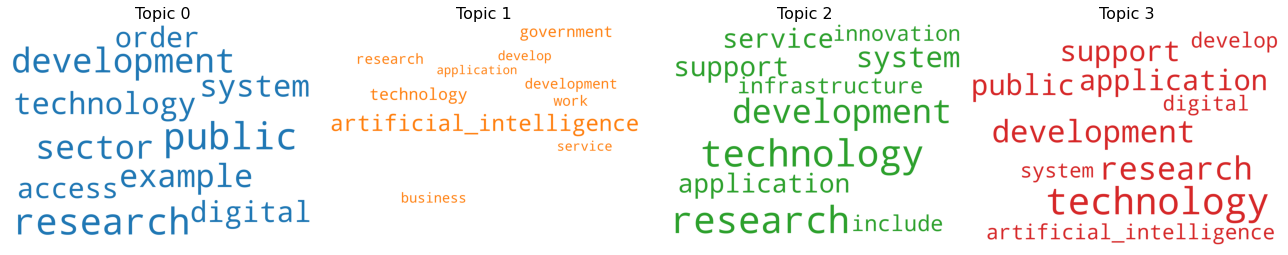

In [72]:
 # 1. Wordcloud of Top N words in each topic


topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, N_TOPICS, figsize=(18,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.max_words=15
    cloud.color_func = lambda *args, **kwargs: word_plotting_colors[i]
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()



## Wordcloud (N-GRAM) Per Topic

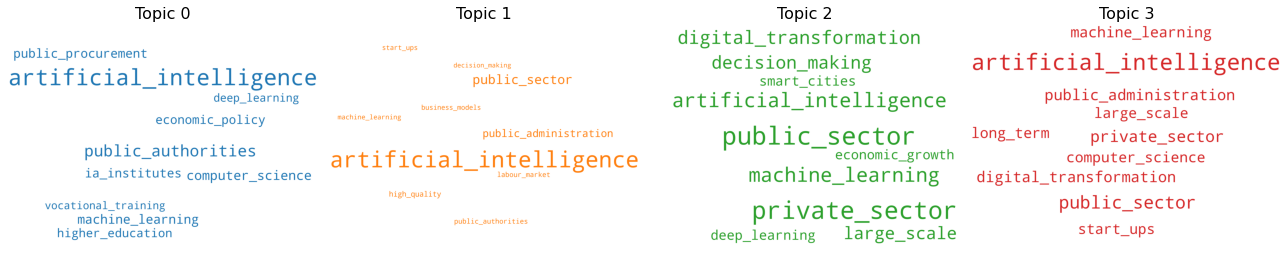

{'artificial_intelligence': 0.00056276564, 'public_sector': 0.0003224205, 'private_sector': 0.00026189894, 'public_administration': 0.00023490221, 'digital_transformation': 0.00023242555, 'machine_learning': 0.00022608171, 'long_term': 0.00021967989, 'computer_science': 0.00021673673, 'start_ups': 0.00021423657, 'large_scale': 0.00021316962, 'decision_making': 0.0002131492, 'deep_learning': 0.00020266979, 'public_authorities': 0.00020015854, 'civil_society': 0.00019873172, 'value_chain': 0.00019725993, 'economic_growth': 0.00019567854, 'intellectual_property': 0.00019544442, 'human_resources': 0.00019523117, 'high_quality': 0.00019465738, 'public_procurement': 0.00019439917, 'wide_range': 0.00019352214, 'human_centric': 0.00019175687, 'real_time': 0.00019172106, 'human_machine': 0.00019142598, 'best_practices': 0.00019103505, 'higher_education': 0.0001904243, 'regulatory_framework': 0.00019022661, 'smart_cities': 0.0001894803, 'ia_institutes': 0.00018939989, 'fundamental_rights': 0.000

In [73]:
topic_ngrams_filter = lambda dict_topic:  {k: v for k, v in dict_topic.items() if '_' in k}
topics = lda_model.show_topics(num_words=1000,formatted=False)


fig, axes = plt.subplots(1, N_TOPICS, figsize=(18,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = topic_ngrams_filter(dict(topics[i][1]))
    cloud.max_words=10
    cloud.color_func = lambda *args, **kwargs: word_plotting_colors[i]
    cloud.generate_from_frequencies(topic_words, max_font_size=200)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

print(topic_ngrams_filter(dict(topics[i][1])))

In [74]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(N_TOPICS), plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 12 nearest neighbors...
[t-SNE] Indexed 13 samples in 0.000s...
[t-SNE] Computed neighbors for 13 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 13 / 13
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.701553
[t-SNE] KL divergence after 1000 iterations: 0.294341


Loading BokehJS ...

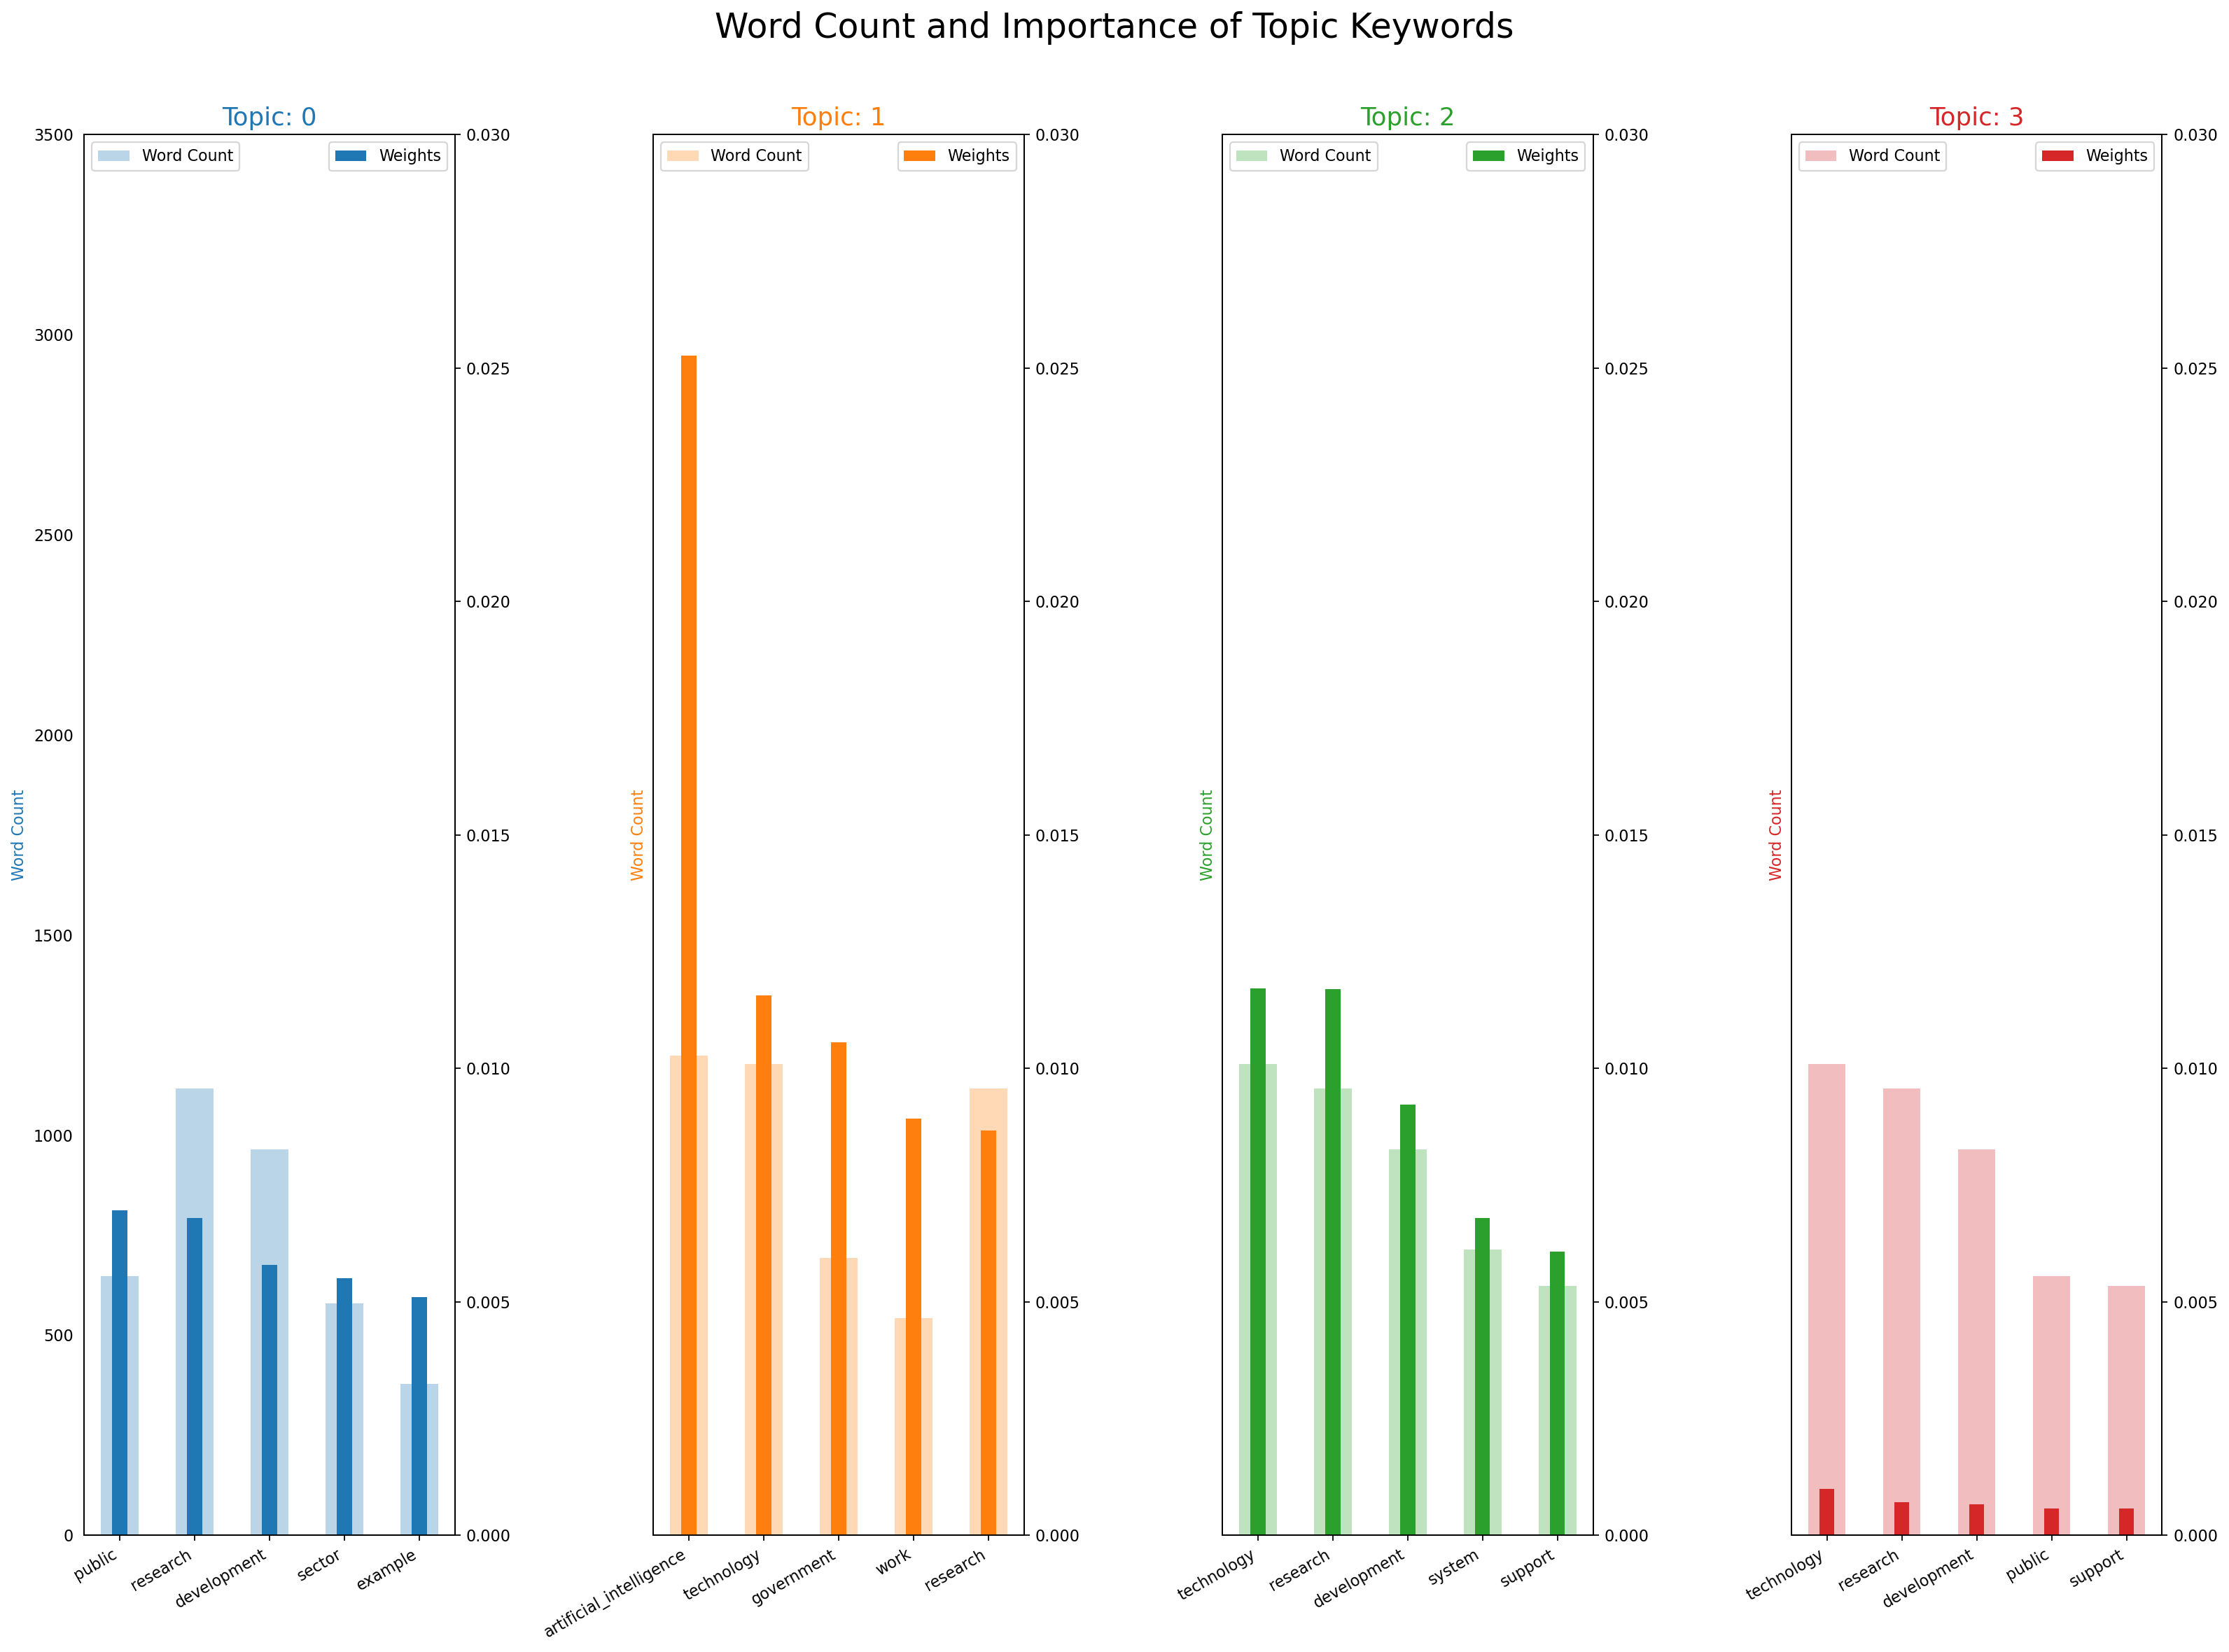

In [75]:
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
from collections import Counter
topics = lda_model.show_topics(formatted=False,num_words=5)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(1, N_TOPICS, figsize=(20,14), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## pyLDAVis

In [76]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word,sort_topics=False)
vis

ModuleNotFoundError: No module named 'pyLDAvis'